In [26]:
import spatialdata
import spatialdata_plot
import dask_image.imread
import dask.array as da
import napari_spatialdata
import matplotlib.pyplot as plt
from matplotlib import patches
import geopandas as gpd
import anndata as ad

import sys, os
sys.path.append(os.path.abspath("../src/opendvp/"))
import anndata_utils

for package in [spatialdata, napari_spatialdata]:
    print(f"{package.__name__}: {package.__version__}")

#paths
path_to_mIF_image = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/processed_images/991.ome.tif"
path_to_HE_image = "/Volumes/Extreme SSD/P26_BCCN/P26_HE_staining/240624_SF_P26_mDVP_991_HE.ome.tiff"
path_to_mask = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/expanded-masks/991.tif"
path_to_quant = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/quantification/991.csv"

spatialdata: 0.3.0
napari_spatialdata: 0.5.5


# Create sdata

In [2]:
! mamba list

# packages in environment at /opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata:
#
# Name                    Version                   Build  Channel
aiobotocore               2.5.4                    pypi_0    pypi
aiohappyeyeballs          2.4.6              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.13         py312h998013c_0    conda-forge
aioitertools              0.12.0                   pypi_0    pypi
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
alabaster                 1.0.0              pyhd8ed1ab_1    conda-forge
anndata                   0.11.3             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0              pyhd8ed1ab_1    conda-forge
aom                       3.9.1                h7bae524_0    conda-forge
app-model                 0.3.0              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4              pyhd8ed1ab_1    conda-forge
appnope                   0.1.4              pyhd8ed1ab_

In [3]:
sdata = spatialdata.SpatialData()

## images and mask

In [4]:
#parse in images

sdata['mIF'] = spatialdata.models.Image2DModel.parse(
    data=dask_image.imread.imread(path_to_mIF_image),
    dims=['c', 'y', 'x'],
    transformations=None,
    scale_factors=[3,3,3],
    )

In [5]:
#parse labels
sdata['mask'] = spatialdata.models.Labels2DModel.parse(
    data=da.squeeze(dask_image.imread.imread(path_to_mask)),
    dims=['y','x'],
    scale_factors=[3,3,3],
    )

In [6]:
sdata.write("../data/sdata/sdata_1_mIF_mask.zarr")

INFO     The Zarr backing store has been changed from None the new file path: ../data/sdata/sdata_1_mIF_mask.zarr  


In [8]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_1_mIF_mask.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
└── Labels
      └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels)

In [9]:
sdata['mask_polygons'] = spatialdata.to_polygons(sdata['mask'])

In [12]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_2_mIF_mask_maskpoly.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
└── Shapes
      └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), mask_polygons (Shapes)

In [11]:
sdata.write("../data/sdata/sdata_2_mIF_mask_maskpoly.zarr")

INFO     The Zarr backing store has been changed from ../data/sdata/sdata_1_mIF_mask.zarr the new file path:       
         ../data/sdata/sdata_2_mIF_mask_maskpoly.zarr                                                              


## link polygons

In [26]:
sdata['mask_polygons']['label'] = sdata['mask_polygons']['label'].astype('int')
sdata['mask_polygons'].index = sdata['mask_polygons'].index.astype('int')
sdata['mask_polygons']['label']

label
1              1
2              2
3              3
4              4
5              5
           ...  
685801    685801
685802    685802
685803    685803
685804    685804
685805    685805
Name: label, Length: 685805, dtype: int64

In [19]:
adata_imaging = anndata_utils.read_quant("../data/imaging/991.csv")

2025-02-26 11:48:33.714 | INFO     | anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-02-26 11:48:37.313 | INFO     | anndata_utils:read_quant:36 -  685805 cells and 75 variables
2025-02-26 11:48:37.314 | INFO     | anndata_utils:read_quant:37 -  ---- read_quant is done, took 3s  ----


In [33]:
adata_imaging.obs['CellID'] = adata_imaging.obs['CellID'] + 1
adata_imaging.obs.index = adata_imaging.obs.index.astype("int") + 1
adata_imaging.obs['CellID'] 

1              2
2              3
3              4
4              5
5              6
           ...  
685801    685802
685802    685803
685803    685804
685804    685805
685805    685806
Name: CellID, Length: 685805, dtype: int64

In [35]:
adata_imaging.obs['CellID'] 

1              1
2              2
3              3
4              4
5              5
           ...  
685801    685801
685802    685802
685803    685803
685804    685804
685805    685805
Name: CellID, Length: 685805, dtype: int64

In [ ]:
def check_link(sdata, shape_element_key, adata, adata_obs_key):
    shape_index = sdata[shape_element_key].index.to_list()
    cell_ids = adata.obs[adata_obs_key].to_list()
    assert shape_index[:5] == cell_ids[:5], "First 5 CellIDs do not match."
    assert shape_index[-5:] == cell_ids[-5:], "Last 5 CellIDs do not match."
    assert sdata[shape_element_key].index.dtype == adata.obs[adata_obs_key].dtype, "Data types do not match."
    print("Success, no problems found")

In [37]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_2_mIF_mask_maskpoly.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
└── Shapes
      └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), mask_polygons (Shapes)

In [41]:
check_link(
    sdata=sdata,
    shape_element_key="mask_polygons",
    adata=adata_imaging,
    adata_obs_key="CellID")

Success


In [42]:
adata_imaging.obs["shapes"] = "mask_polygons"
adata_imaging.obs["shapes"] = adata_imaging.obs["shapes"].astype("category")
sdata["imaging"] = spatialdata.models.TableModel.parse(adata_imaging, region = "mask_polygons", region_key = "shapes", instance_key = "CellID")

In [43]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_2_mIF_mask_maskpoly.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (685805, 75)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), mask_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ imaging (Tables)

In [44]:
sdata.write("../data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr")

INFO     The Zarr backing store has been changed from ../data/sdata/sdata_2_mIF_mask_maskpoly.zarr the new file    
         path: ../data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr                                          


In [3]:
sdata = spatialdata.read_zarr("../data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (685805, 75)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), mask_polygons (Shapes)

In [ ]:
# napari check
interactive = napari_spatialdata.Interactive(sdata)
interactive.run()
# check that imaging table plots on top of polygons matched by CellID

: 

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_10470/1256935928.py:12: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_shapes.render_shapes` in spatialdata_plot version 0.3.0, switch to `element` instead.
  sdata.pl.render_shapes(elements="mask_polygons").pl.show(ax=ax)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


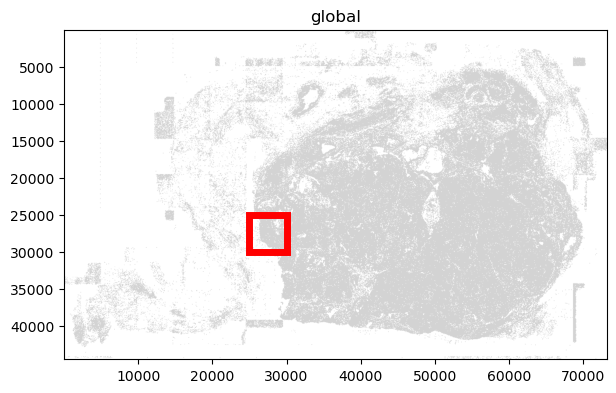

In [12]:
# loading shapes takes very long
# lets subset

bb_xmin = 25000
bb_ymin = 25000
bb_w = 5000
bb_h = 5000
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

f, ax = plt.subplots(figsize=(7, 7))
sdata.pl.render_shapes(elements="mask_polygons").pl.show(ax=ax)
rect = patches.Rectangle((bb_xmin, bb_ymin), bb_w, bb_h, linewidth=5, edgecolor="red", facecolor="none")
ax.add_patch(rect)

In [13]:
cropped_sdata = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
    filter_table=True,
)

In [14]:
cropped_sdata

SpatialData object
├── Images
│     └── 'mIF': DataTree[cyx] (15, 5000, 5000), (15, 1667, 1667), (15, 555, 555), (15, 185, 185)
├── Labels
│     └── 'mask': DataTree[yx] (5000, 5000), (1667, 1667), (555, 555), (185, 185)
├── Shapes
│     └── 'mask_polygons': GeoDataFrame shape: (9890, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (9890, 75)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), mask_polygons (Shapes)

In [15]:
# napari check
interactive = napari_spatialdata.Interactive(cropped_sdata)
interactive.run()

## Add qupath annotations, the geojsons

In [16]:
path_to_annotations = "../data/geojsons/Primary/processed/20241129_1442_Primary991_harmonized.geojson"

In [18]:
gdf = gpd.read_file(path_to_annotations)

In [21]:
gdf.harmonized_class.unique()

array(['Primary_Immune_1', 'Primary_Immune_2', 'Primary_Immune_3',
       'Primary_TumorBed_1', 'Primary_TumorBed_2', 'Primary_TumorBed_3',
       'Primary_Interface_1', 'Primary_Interface_2',
       'Primary_Interface_3'], dtype=object)

In [22]:
gdf.head()

AttributeError: 'NoneType' object has no attribute 'copy'

,id,objectType,name,classification,class,harmonized_class,geometry
0,4901bc90-bd70-412d-a441-0ff05dfa35a4,annotation,None,"{ ""name"": ""991_DI_1"", ""color"": [ 165, 218, 209...",991_DI_1,Primary_Immune_1,"POLYGON ((44720 36407.5, 44719.55 36421.72, 44..."
1,677c08c8-1578-4d40-9004-56770e72c0ed,annotation,None,"{ ""name"": ""991_DI_1"", ""color"": [ 165, 218, 209...",991_DI_1,Primary_Immune_1,"POLYGON ((44919 36928.5, 44918.55 36942.72, 44..."
2,31712a3a-4a0f-4304-b598-e418e29bcf57,annotation,None,"{ ""name"": ""991_DI_1"", ""color"": [ 165, 218, 209...",991_DI_1,Primary_Immune_1,"POLYGON ((44226 36725.5, 44225.55 36739.72, 44..."
3,c49bf319-03ad-42e1-8aac-3a9cd916876b,annotation,None,"{ ""name"": ""991_DI_1"", ""color"": [ 165, 218, 209...",991_DI_1,Primary_Immune_1,"POLYGON ((44843 37430.5, 44842.55 37444.72, 44..."
4,a27e7237-df76-4e5b-8bbf-3fb57ab6c7c4,annotation,None,"{ ""name"": ""991_DI_2"", ""color"": [ 165, 12, 79 ] }",991_DI_2,Primary_Immune_2,"POLYGON ((47400 38154, 47399.6 38166.81, 47398..."


In [23]:
gdf.index = gdf.harmonized_class.values
gdf.head()

AttributeError: 'NoneType' object has no attribute 'copy'

,id,objectType,name,classification,class,harmonized_class,geometry
Primary_Immune_1,4901bc90-bd70-412d-a441-0ff05dfa35a4,annotation,None,"{ ""name"": ""991_DI_1"", ""color"": [ 165, 218, 209...",991_DI_1,Primary_Immune_1,"POLYGON ((44720 36407.5, 44719.55 36421.72, 44..."
Primary_Immune_1,677c08c8-1578-4d40-9004-56770e72c0ed,annotation,None,"{ ""name"": ""991_DI_1"", ""color"": [ 165, 218, 209...",991_DI_1,Primary_Immune_1,"POLYGON ((44919 36928.5, 44918.55 36942.72, 44..."
Primary_Immune_1,31712a3a-4a0f-4304-b598-e418e29bcf57,annotation,None,"{ ""name"": ""991_DI_1"", ""color"": [ 165, 218, 209...",991_DI_1,Primary_Immune_1,"POLYGON ((44226 36725.5, 44225.55 36739.72, 44..."
Primary_Immune_1,c49bf319-03ad-42e1-8aac-3a9cd916876b,annotation,None,"{ ""name"": ""991_DI_1"", ""color"": [ 165, 218, 209...",991_DI_1,Primary_Immune_1,"POLYGON ((44843 37430.5, 44842.55 37444.72, 44..."
Primary_Immune_2,a27e7237-df76-4e5b-8bbf-3fb57ab6c7c4,annotation,None,"{ ""name"": ""991_DI_2"", ""color"": [ 165, 12, 79 ] }",991_DI_2,Primary_Immune_2,"POLYGON ((47400 38154, 47399.6 38166.81, 47398..."


In [41]:
sdata['lmd_contours'] = spatialdata.models.ShapesModel.parse(gdf2)

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `lmd_contours` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [42]:
sdata['lmd_contours']

AttributeError: 'NoneType' object has no attribute 'copy'

,id,objectType,classification,class_name,geometry
0,f28bcc19-9831-427b-9b97-10868325b0e8,annotation,"{ ""name"": ""P26E17_RCN3_3"", ""color"": [ 232, 118...",P26E17_RCN3_3,"POLYGON ((56281 28253, 56280.7 28262.42, 56279..."
1,800e33fd-8073-40aa-8145-526f0a18ba7a,annotation,"{ ""name"": ""P26E17_RCN3_4"", ""color"": [ 232, 187...",P26E17_RCN3_4,"POLYGON ((54544 28839, 54543.7 28848.42, 54542..."
2,9d800822-b37b-4942-8d8d-5c4c7733bd77,annotation,"{ ""name"": ""P26E17_RCN3_6"", ""color"": [ 232, 88,...",P26E17_RCN3_6,"POLYGON ((49930 27689, 49929.7 27698.42, 49928..."
3,2aaea3c4-b633-4ce0-b314-2a2bdc603965,annotation,"{ ""name"": ""P26E17_RCN3_6"", ""color"": [ 232, 88,...",P26E17_RCN3_6,"POLYGON ((50349 28362, 50348.7 28371.42, 50347..."
4,0a74ef15-992d-4e8d-b48f-7aae1d864c6b,annotation,"{ ""name"": ""P26E17_RCN3_20"", ""color"": [ 118, 21...",P26E17_RCN3_20,"POLYGON ((47178 27872, 47177.7 27881.42, 47176..."
...,...,...,...,...,...
229,a17d4675-96a9-4f45-90ae-4b65c6580c25,annotation,"{ ""name"": ""Primary_refill_88"", ""color"": [ 89, ...",Primary_refill_88,"POLYGON ((29895.2 34144.17, 29882.64 34144.56,..."
230,d03c3ea0-a511-4481-968a-b6f3e23f1764,annotation,"{ ""name"": ""Primary_refill_9"", ""color"": [ 178, ...",Primary_refill_9,"POLYGON ((53718.2 24269.17, 53705.64 24269.56,..."
231,21b7eb33-5607-4689-80b4-aa5f27bf9cb8,annotation,"{ ""name"": ""Primary_refill_90"", ""color"": [ 88, ...",Primary_refill_90,"POLYGON ((58865.2 36447.17, 58852.64 36447.56,..."
232,ff29bb1a-ad53-474e-b748-df882882dce4,annotation,"{ ""name"": ""Primary_refill_91"", ""color"": [ 88, ...",Primary_refill_91,"POLYGON ((58754.2 38373.17, 58741.64 38373.56,..."


In [89]:
adata_proteomic = ad.read_h5ad("/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E18_ProteomicAnalysis/data/adatas/20250129_2244_adata.h5ad")
adata_proteomic.obs.columns

Index(['Precursors.Identified', 'Proteins.Identified', 'Total.Quantity',
       'MS1.Signal', 'MS2.Signal', 'FWHM.Scans', 'FWHM.RT',
       'Median.Mass.Acc.MS1', 'Median.Mass.Acc.MS1.Corrected',
       'Median.Mass.Acc.MS2', 'Median.Mass.Acc.MS2.Corrected',
       'MS2.Mass.Instability', 'Normalisation.Instability',
       'Median.RT.Prediction.Acc', 'Average.Peptide.Length',
       'Average.Peptide.Charge', 'Average.Missed.Tryptic.Cleavages',
       'filename', 'Machine', 'Date', 'User_id', 'LC', 'Acquisition', 'Exp_id',
       'Plate_384wp_id', '384wp_well_real', 'Vial', 'Vol_injected',
       'LCMS_run_id', '96wp_well', '96wp_id', 'Biopsy_type', 'RCN', 'RCN_long',
       'replicate', 'class_name'],
      dtype='object')

In [88]:
from shapely.wkt import loads
df = gpd.read_file("/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E18_ProteomicAnalysis/data/shapes/all_shapes.csv")
df["geometry"] = df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)
gdf = gpd.GeoDataFrame(df, geometry="geometry")
gdf.index = gdf.new_class_name.values
sdata['lmd_contours'] = spatialdata.models.ShapesModel.parse(gdf)
sdata

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `lmd_contours` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (685805, 75)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ lmd_contours (Shapes)

In [113]:
adata_proteomic.obs["shapes"] = "lmd_contours"
adata_proteomic.obs["shapes"] = adata_proteomic.obs["shapes"].astype("category")
adata_proteomic.obs['class_name'] = adata_proteomic.obs["class_name"].astype("str")
sdata["proteins"] = spatialdata.models.TableModel.parse(adata_proteomic, region = "lmd_contours", region_key = "shapes", instance_key = "class_name")

In [95]:
adata_proteomic.obs.class_name.value_counts().sort_values()

class_name
Primary_RCN3_15     1
Primary_RCN1_38     1
Primary_RCN1_37     1
Primary_RCN1_3      1
Primary_RCN1_5      1
                   ..
Relapse_RCN5_19     1
Relapse_RCN5_21     1
Relapse_RCN5_22     1
Relapse_RCN5_10     1
Primary_RCN1_164    2
Name: count, Length: 218, dtype: int64

In [ ]:
# this had to be done because somehow there was a sample duplication, digitally it looks legit.
# Somehow sample L10 from relapse plate, appeared in two evotips.. I will keep one for now
adata_proteomic = adata_proteomic[adata_proteomic.obs.LCMS_run_id != 8551].copy()

In [114]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (685805, 75)
      └── 'proteins': AnnData (218, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ proteins (Tables)
    ▸ lmd_contours (Shapes)

In [115]:
sdata.write("../data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr")

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside ../data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr). Please see the documentation of 
         `is_self_contained()` to understand the implications of working with SpatialData objects that are not     
         self-contained.                                                                                           
INFO     The Zarr backing store has been changed from ../data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr   
         the new file path: ../data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr                                  


In [116]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (685805, 75)
      └── 'proteins': AnnData (218, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes)
with the following Dask-backed elements not being self-contained:
    ▸ mIF: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr/images/mIF
    ▸ mask: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sda

In [117]:
del sdata
sdata = spatialdata.read_zarr("../data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [118]:
interactive = napari_spatialdata.Interactive(sdata)
interactive.run()